# Train custom segmentation model with `IceVision`, `OpenImages`, and `SageMaker`
## Serving PyTorch Models In Production With BYOC And Amazon Sagemaker

Sources:
- https://github.com/aws-samples/amazon-sagemaker-endpoint-deployment-of-fastai-model-with-torchserve

In [60]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

## Import libraries

In [98]:
import base64
import json
import io
import requests
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path
from urllib.request import urlopen

## Configuration

In [62]:
import boto3
import sagemaker
from sagemaker import get_execution_role

### IAM Role

Your `IAM Role` needs to have the following policies:  
- `AmazonS3FullAccess`  
- `AmazonEC2ContainerRegistryFullAccess`  
- `AmazonSageMakerFullAccess`  

In [63]:
role = get_execution_role()
account_id = role.split(':')[4]
region = boto3.Session().region_name
sagemaker_session = sagemaker.session.Session()
bucket = sagemaker_session.default_bucket()

In [64]:
print(f'account_id: "{account_id}"')
print(f'region: "{region}"')
print(f'role: "{role}"')
print(f'bucket: "{bucket}"')

account_id: "849118573017"
region: "eu-west-2"
role: "arn:aws:iam::849118573017:role/service-role/AmazonSageMaker-ExecutionRole-20210113T160042"
bucket: "sagemaker-eu-west-2-849118573017"


## Build and Push Container
We are now ready to build this container and push it to Amazon ECR. This task is executed using a shell script stored in the ../script/ folder. Let's take a look at this script and then execute it.

### Configure Amazon Elastic Container Registry (`ECR`)

In [65]:
ecr_namespace = 'torchserve-sagemaker/'
prefix = 'background-removal'
ecr_repository_name = ecr_namespace + prefix

In [66]:
image = f"{account_id}.dkr.ecr.{region}.amazonaws.com/{ecr_repository_name}:latest"
image

'849118573017.dkr.ecr.eu-west-2.amazonaws.com/torchserve-sagemaker/background-removal:latest'

### Pytorch Model Artifacts

Create a compressed `*.tar.gz` file from the `*.mar` file per requirement of Amazon SageMaker and upload the model to your Amazon S3 bucket. Your file needs to be in the top-level (https://github.com/shashankprasanna/torchserve-examples/issues/3)

In [67]:
model_artifacts_folder = '../model_store'
model_file_name = [x.stem for x in Path(model_artifacts_folder).glob('*.mar')][0]

In [68]:
!cd {model_artifacts_folder} && tar cvzf {model_file_name}.tar.gz {model_file_name}.mar
!cd {model_artifacts_folder} && aws s3 cp {model_file_name}.tar.gz s3://{bucket}/torchserve_model_store/

mask-rcnn-remove-bkg.mar
upload: ./mask-rcnn-remove-bkg.tar.gz to s3://sagemaker-eu-west-2-849118573017/torchserve_model_store/mask-rcnn-remove-bkg.tar.gz


### Build Torchserve Docker Container and Push to Amazon ECR

In [69]:
path_to_dockerfile_folder = '../deployment_code/'

In [71]:
!aws ecr get-login-password --region {region} | docker login --username AWS --password-stdin {account_id}.dkr.ecr.{region}.amazonaws.com
!aws ecr describe-repositories --repository-names $ecr_repository_name || aws ecr create-repository --repository-name $ecr_repository_name
!docker build -t {ecr_repository_name} {path_to_dockerfile_folder}
!docker tag {ecr_repository_name}:latest {image}
!docker push {image}

WARNING! Your password will be stored unencrypted in /home/ec2-user/.docker/config.json.
Configure a credential helper to remove this warning. See
https://docs.docker.com/engine/reference/commandline/login/#credentials-store

Login Succeeded
{
    "repositories": [
        {
            "repositoryArn": "arn:aws:ecr:eu-west-2:849118573017:repository/torchserve-sagemaker/background-removal",
            "registryId": "849118573017",
            "repositoryName": "torchserve-sagemaker/background-removal",
            "repositoryUri": "849118573017.dkr.ecr.eu-west-2.amazonaws.com/torchserve-sagemaker/background-removal",
            "createdAt": 1617816642.0,
            "imageTagMutability": "MUTABLE",
            "imageScanningConfiguration": {
                "scanOnPush": false
            },
            "encryptionConfiguration": {
                "encryptionType": "AES256"
            }
        }
    ]
}
Sending build context to Docker daemon  78.34kB
Step 1/16 : FROM pytorch/pytorc

## Inference Endpoint

### Create Sagemaker Model


In [74]:
model_data = f"s3://{bucket}/torchserve_model_store/{model_file_name}.tar.gz"
sm_model_name = model_file_name

container = {"Image": image, "ModelDataUrl": model_data}

create_model_response = sagemaker_session.create_model(
    name=sm_model_name, role=role, container_defs=container)

### Endpoint configuration

**Note**: choose your preferred `InstanceType`: https://aws.amazon.com/sagemaker/pricing/

In [75]:
deployment_instance_type = "ml.g4dn.xlarge"

In [76]:
import time

endpoint_config_name = f"{model_file_name}-endpoint-config-" + time.strftime(
    "%Y-%m-%d-%H-%M-%S", time.gmtime()
)
print(endpoint_config_name)

create_endpoint_config_response = sagemaker_session.create_endpoint_config(
    name=endpoint_config_name,
    model_name = sm_model_name,
    initial_instance_count = 1,
    instance_type = deployment_instance_type,
)

mask-rcnn-remove-bkg-endpoint-config-2021-04-12-10-57-41


Deployment time will take around 7-10 minutes

In [78]:
endpoint_name = f"{model_file_name}-endpoint-" + time.strftime(
    "%Y-%m-%d-%H-%M-%S", time.gmtime()
)
print(endpoint_name)

create_endpoint_response = sagemaker_session.create_endpoint(
    endpoint_name=endpoint_name, config_name=endpoint_config_name
)

mask-rcnn-remove-bkg-endpoint-2021-04-12-10-57-43
---------------!

### Testing

In [94]:
def get_image_bytes(path:str):
    try:
        response = requests.get(path)
        data = urlopen(path)
    except Exception:
        data = open(path,'rb')
    return data.read()

In [102]:
# path_to_image = 'https://df2sm3urulav.cloudfront.net/tenants/ca/uploads/images/0-4999/1601/5d82a21c1abf4.jpg'
path_to_image = 'test_images/FindID_161098.jpg'

payload = get_image_bytes(path_to_image)

In [103]:
%%time
client = boto3.client("runtime.sagemaker")
response = client.invoke_endpoint(
    EndpointName=endpoint_name, ContentType="application/x-image", Body=payload, 
)
response = json.loads(response["Body"].read())

CPU times: user 52.1 ms, sys: 764 µs, total: 52.9 ms
Wall time: 2 s


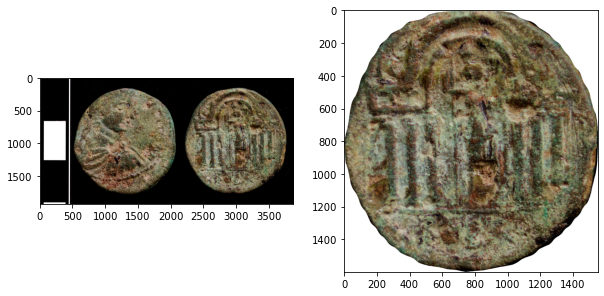

In [104]:
target_image = Image.open(io.BytesIO(payload))
predicted_image = Image.open(io.BytesIO(base64.b64decode(response['base64_prediction'])))

f = plt.figure(figsize=(10,10))
f.add_subplot(1,2,1)
plt.imshow(target_image)
f.add_subplot(1,2, 2)
plt.imshow(predicted_image)
plt.show(block=True)

### Clean-up

In [72]:
client = boto3.client("sagemaker")
client.delete_model(ModelName=sm_model_name)
client.delete_endpoint(EndpointName=endpoint_name)
client.delete_endpoint_config(EndpointConfigName=endpoint_config_name)

{'ResponseMetadata': {'RequestId': '82691546-1751-4838-8be2-cd63253e9095',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '82691546-1751-4838-8be2-cd63253e9095',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '0',
   'date': 'Mon, 12 Apr 2021 10:57:17 GMT'},
  'RetryAttempts': 0}}

## References

### Images included in `test_images` folder

- ["File:Roman Provincial coin of Elagabalus (FindID 161098).jpg"](https://commons.wikimedia.org/w/index.php?curid=55927196) by Winchester Museum Service, Laura McLean, 2007-02-26 21:11:56 is licensed under [CC BY-SA 2.0](https://creativecommons.org/licenses/by-sa/2.0?ref=ccsearch&atype=rich)
- ["File:As of Maximinus I (obverse) (FindID 401752).jpg"](https://commons.wikimedia.org/w/index.php?curid=55261869) by Royal Institution of Cornwall, Anna Tyacke, 2010-08-06 17:24:21 is licensed under [CC BY-SA 2.0](https://creativecommons.org/licenses/by-sa/2.0?ref=ccsearch&atype=rich)